In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def eliminate_features(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    
    important_features = utils.display_important_features(classifier.feature_importances_, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats


#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [3]:
# earliest season data starts in 2000 corresponding to tournament season date of 2001
tournament_season = 2003

In [4]:
summary_data = pd.read_csv(Path( '../Data/sr_summaries_kaggle_id_no_opp.csv'))

# drop opponent stat columns
summary_data.drop(columns=['allow_fg_pct','allow_ft_att_avg','allow_off_rebs_avg','allow_def_rebs_avg' ], inplace=True)

print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]

(5687, 18)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
180,2000,New Orleans,e7ff6d5c-07e9-42af-955d-0a0b8c1e2288,29,-1.95,-3.83,0.586,69,65,0.457,0.680,NaN,NaN,NaN,15,7,NaN,22
398,2001,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,28,-14.55,-7.48,0.321,66,73,0.403,0.656,NaN,NaN,NaN,17,7,NaN,22
489,2001,Morris Brown,NaN,29,-26.38,-1.84,0.172,55,75,0.372,0.582,NaN,NaN,NaN,19,6,NaN,19
718,2002,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,29,-10.58,-10.30,0.586,71,71,0.431,0.677,NaN,NaN,NaN,17,7,NaN,24
811,2002,Morris Brown,NaN,28,-25.25,-10.21,0.286,63,75,0.405,0.629,NaN,NaN,NaN,16,6,NaN,22
983,2003,Birmingham-Southern,NaN,27,-3.27,-9.79,0.741,74,65,0.482,0.695,NaN,NaN,NaN,15,7,NaN,21
1043,2003,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,32,-9.85,-7.94,0.469,72,74,0.415,0.708,NaN,NaN,NaN,16,8,NaN,24
1308,2004,Birmingham-Southern,NaN,30,-7.24,-8.24,0.533,65,63,0.445,0.721,NaN,NaN,NaN,13,5,NaN,22
1368,2004,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,29,-15.06,-9.24,0.483,68,73,0.425,0.657,NaN,NaN,NaN,17,7,NaN,21
1633,2005,Birmingham-Southern,NaN,28,-5.81,-8.12,0.679,68,64,0.462,0.682,NaN,NaN,NaN,12,6,NaN,21


In [5]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)
summary_data[summary_data.isnull().any(axis=1)]

(5673, 18)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg


In [6]:
summary_data.rename(str.lower, axis='columns', inplace=True)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [7]:
# Read table of team names and associated team meta data
teams = pd.read_csv(Path('../Data/D1_teams.csv'))
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [8]:
tourney_data = pd.read_csv(Path('../Data/tournament_results.csv'))
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)



tourney_data.describe()

,season,round,win_seed,lose_seed
count,2117.000000,2117.000000,2117.000000,2117.000000
mean,2001.193198,43.776098,4.924894,8.706188
std,9.563883,22.403689,3.786171,4.601165
min,1985.000000,2.000000,1.000000,1.000000
25%,1993.000000,32.000000,2.000000,5.000000
50%,2001.000000,64.000000,4.000000,9.000000
75%,2010.000000,64.000000,7.000000,13.000000
max,2017.000000,68.000000,16.000000,16.000000


In [9]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [10]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

In [11]:
tourney_data = tourney_data[tourney_data['season'] >= tournament_season]
tourney_data.describe()['season']

count     981.000000
mean     2010.085627
std         4.325153
min      2003.000000
25%      2006.000000
50%      2010.000000
75%      2014.000000
max      2017.000000
Name: season, dtype: float64

In [12]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.rename(columns={"team_seed":"seed_t","opp_team_seed":"seed_o"}, inplace=True)

tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))

tourney_data.drop(columns=['school_t','school_o','games_t','games_o','team_id_o'],inplace=True)

tourney_data = tourney_data.join(teams, on='team_id_t', how='left')
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.rename(index=str,columns={'team':'team_t','opp_team':'team_o', 'opp_team_id':'team_id_o'},inplace=True)

tourney_data['game_result'] = tourney_data.game_result.apply(utils.negate_loser)
tourney_data.head()



,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,2012.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,2010.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,2012.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,2011.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,2010.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10


In [13]:
computer_rankings = pd.read_csv(Path( '../Data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season']>= tournament_season]


In [14]:
temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t','team_id_t'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))

temp_merge.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
temp_merge.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG,WLK,WOL,RTH,COL,POM,DOL,RPI,MOR
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,2012.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,2010.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,2012.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,2011.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,2010.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3


In [15]:
tourney_comp_ratings = temp_merge.merge(computer_rankings,left_on=['season_t','team_id_o'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

tourney_comp_ratings.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)

tourney_comp_ratings.rename(str.lower, axis='columns', inplace=True)
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,2012.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,2010.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,2012.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,2011.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,2010.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [16]:
print(top_tournament_conferences_list)
tourney_comp_ratings['top_conf'] = tourney_comp_ratings.apply(lambda row: utils.conf_compare(row.conf_name_t, 
                                                                                             row.conf_name_o,
                                                                                             top_tournament_conferences_list),
                                                              axis=1)

tourney_comp_ratings.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,-1,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,-1,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,-1,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,-1,Atlantic Coast,Atlantic 10,1
7,1,Atlantic 10,Big Ten,-1
8,-1,Big East,Atlantic 10,0
9,1,Atlantic 10,Pacific 12,-1


In [17]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_comp_ratings['upset_seed_threshold'] = tourney_comp_ratings.apply(
    lambda row: abs(row.seed_t - row.seed_o) > 6, axis=1).astype(int)
    
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,2012.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,2010.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,2012.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,2011.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,2010.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1


In [18]:
tourney_comp_ratings['margin_victory_avg_t'] = tourney_comp_ratings['pts_avg_t'] - tourney_comp_ratings['opp_pts_avg_t']
tourney_comp_ratings['margin_victory_avg_o'] = tourney_comp_ratings['pts_avg_o'] - tourney_comp_ratings['opp_pts_avg_o']

tourney_comp_ratings['delta_margin_victory_avg'] = tourney_comp_ratings['margin_victory_avg_t'] - \
    tourney_comp_ratings['margin_victory_avg_o']

tourney_comp_ratings['delta_fg_pct'] = tourney_comp_ratings['fg_pct_t'] - tourney_comp_ratings['fg_pct_o']

tourney_comp_ratings['delta_off_rebs_avg'] = tourney_comp_ratings['off_rebs_avg_t'] - tourney_comp_ratings['off_rebs_avg_o']

tourney_comp_ratings['delta_def_rebs_avg'] = tourney_comp_ratings['def_rebs_avg_t'] - tourney_comp_ratings['def_rebs_avg_o']

tourney_comp_ratings['delta_ft_pct'] = tourney_comp_ratings['ft_pct_t'] - tourney_comp_ratings['ft_pct_o']

tourney_comp_ratings['to_net_avg_t'] = tourney_comp_ratings['to_avg_t'] - tourney_comp_ratings['steal_avg_t']

tourney_comp_ratings['to_net_avg_o'] = tourney_comp_ratings['to_avg_o'] - tourney_comp_ratings['steal_avg_o']

tourney_comp_ratings['delta_to_net_avg'] = tourney_comp_ratings['to_net_avg_t'] - tourney_comp_ratings['to_net_avg_o']

tourney_comp_ratings['delta_win_pct'] = tourney_comp_ratings['win_pct_t'] - tourney_comp_ratings['win_pct_o']

tourney_comp_ratings['delta_off_rating'] = tourney_comp_ratings['off_rating_t'] - tourney_comp_ratings['off_rating_o']


tourney_comp_ratings['delta_ft_att_avg'] = tourney_comp_ratings['ft_att_avg_t'] - tourney_comp_ratings['ft_att_avg_o']

tourney_comp_ratings['delta_seed'] = tourney_comp_ratings['seed_t'] - tourney_comp_ratings['seed_o']

tourney_comp_ratings['delta_srs'] = tourney_comp_ratings['srs_t'] - tourney_comp_ratings['srs_o']
tourney_comp_ratings['delta_sos'] = tourney_comp_ratings['sos_t'] - tourney_comp_ratings['sos_o']

tourney_comp_ratings['delta_sag'] = tourney_comp_ratings['sag_t'] - tourney_comp_ratings['sag_o']
tourney_comp_ratings['delta_wlk'] = tourney_comp_ratings['wlk_t'] - tourney_comp_ratings['wlk_o']
tourney_comp_ratings['delta_wol'] = tourney_comp_ratings['wol_t'] - tourney_comp_ratings['wol_o']
tourney_comp_ratings['delta_rth'] = tourney_comp_ratings['rth_t'] - tourney_comp_ratings['rth_o']
tourney_comp_ratings['delta_col'] = tourney_comp_ratings['col_t'] - tourney_comp_ratings['col_o']
tourney_comp_ratings['delta_pom'] = tourney_comp_ratings['pom_t'] - tourney_comp_ratings['pom_o']
tourney_comp_ratings['delta_dol'] = tourney_comp_ratings['dol_t'] - tourney_comp_ratings['dol_o']
tourney_comp_ratings['delta_rpi'] = tourney_comp_ratings['rpi_t'] - tourney_comp_ratings['rpi_o']
tourney_comp_ratings['delta_mor'] = tourney_comp_ratings['mor_t'] - tourney_comp_ratings['mor_o']


tourney_comp_ratings.drop(columns=['season_o'], inplace=True)


In [19]:
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
513,2004,68,2004-03-16,16,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,16,Lehigh,508f503f-dc57-4f4c-a01e-4f195e5c05c8,1,2003,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.30,-8.88,0.645,67.0,63.0,0.424,0.716,77.612903,11.0,25.0,14.0,7.0,86.325852,19.0,Mid Eastern Athletic,Patriot League,287,275.0,287,289,261.0,276.0,276.0,262.0,255,222,194.0,204,224,181.0,218.0,182.0,194.0,212,0,0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,0,NaN,NaN,65,81.0,83,65,80.0,58.0,94.0,68.0,43
614,2004,64,2004-03-19,16,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,1,Kentucky,2267a1f4-68f6-418b-aaf6-2aa0c4b291f1,-1,2003,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.83,8.55,0.844,73.0,63.0,0.472,0.697,79.587500,11.0,24.0,14.0,7.0,91.722946,19.0,Mid Eastern Athletic,Southeastern,287,275.0,287,289,261.0,276.0,276.0,262.0,255,4,3.0,2,3,1.0,4.0,5.0,2.0,2,-1,1,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,15,NaN,NaN,283,272.0,285,286,260.0,272.0,271.0,260.0,253
947,2007,68,2007-03-13,16,Niagara,f7575278-12ec-494a-b544-427c1759d43d,16,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,1,2006,Win,-3.41,-4.7,0.657,75.0,74.0,0.418,0.731,83.645714,14.0,23.0,13.0,6.0,89.663889,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Metro Atlantic Athletic,Mid Eastern Athletic,162,152.0,152,173,142.0,169.0,138.0,136.0,143,231,204.0,180,235,180.0,256.0,208.0,171.0,248,0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,-69,-52.0,-28,-62,-38.0,-87.0,-70.0,-35.0,-105


In [20]:
tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [21]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','seed_t','team_t','team_id_t','team_id_o',
                                         'team_o','seed_o','team_id_o','game_result','start_season','game result',
                                         'conf_name_t','conf_name_o']).copy()


feature_data.head()

,season_t,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0,7.0,5.0,2.0,0.068,0.0,3.0,-0.042,6.0,3.0,3.0,-0.020,5.261076,3.0,-1,4.80,1.97,-30,-31.0,1,-19,-8.0,-33.0,-13.0,-8.0,-28
1,2011,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0,8.0,1.0,7.0,0.008,2.0,3.0,-0.026,4.0,6.0,-2.0,0.206,0.300109,3.0,-3,0.37,-7.22,-13,-12.0,-18,-5,-12.0,-1.0,-14.0,-9.0,18
2,2013,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1,9.0,12.0,-3.0,0.005,-1.0,3.0,-0.058,6.0,0.0,6.0,0.038,-3.771096,2.0,7,-8.78,-4.29,36,36.0,25,32,23.0,33.0,15.0,18.0,44
3,2012,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9.0,15.0,-6.0,-0.072,2.0,-6.0,-0.063,1.0,6.0,-5.0,-0.012,-10.243325,1.0,7,-8.63,-3.17,40,33.0,16,38,24.0,37.0,18.0,26.0,45
4,2011,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1,17.0,5.0,12.0,0.074,1.0,6.0,-0.036,6.0,3.0,3.0,0.221,6.725684,2.0,-10,15.54,3.84,-75,-53.0,-51,-72,-58.0,-81.0,-70.0,-48.0,-77


In [22]:
feature_data.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_avg_t', 'margin_victory_avg_o',
                                'poss_avg_t','poss_avg_o',
                                'fg_pct_t','fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                 'ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'srs_t','srs_o','sos_t','sos_o',
                                'sag_t','sag_o','wlk_t','wlk_o','wol_t','wol_o',
                                'rth_t','rth_o','col_t','col_o','pom_t','pom_o',
                                'dol_t','dol_o','rpi_t','rpi_o','mor_t','mor_o'], inplace=True)




feature_data.head()

,season_t,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,1,0,2.0,0.068,0.0,3.0,-0.042,3.0,-0.020,5.261076,3.0,-1,4.80,1.97,-30,-31.0,1,-19,-8.0,-33.0,-13.0,-8.0,-28
1,2011,-1,0,7.0,0.008,2.0,3.0,-0.026,-2.0,0.206,0.300109,3.0,-3,0.37,-7.22,-13,-12.0,-18,-5,-12.0,-1.0,-14.0,-9.0,18
2,2013,0,1,-3.0,0.005,-1.0,3.0,-0.058,6.0,0.038,-3.771096,2.0,7,-8.78,-4.29,36,36.0,25,32,23.0,33.0,15.0,18.0,44
3,2012,0,1,-6.0,-0.072,2.0,-6.0,-0.063,-5.0,-0.012,-10.243325,1.0,7,-8.63,-3.17,40,33.0,16,38,24.0,37.0,18.0,26.0,45
4,2011,1,1,12.0,0.074,1.0,6.0,-0.036,3.0,0.221,6.725684,2.0,-10,15.54,3.84,-75,-53.0,-51,-72,-58.0,-81.0,-70.0,-48.0,-77


In [63]:
X= feature_data[feature_data['season_t']>= tournament_season]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']>= tournament_season]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['top_conf',
 'upset_seed_threshold',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

#### Classic Train Validate Test

In [64]:
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, test_size=0.25, random_state = 5)
print("Total games= ", X.shape[0])
print("X Train: ",X_train.shape)
print(y_train.shape)
print("X Validate: ",X_validate.shape)
print(y_validate.shape)
print("X Test: ",X_test.shape)
print(y_test.shape)

Total games=  978
X Train:  (586, 23)
(586,)
X Validate:  (196, 23)
(196,)
X Test:  (196, 23)
(196,)


In [65]:
number_estimators = 201

bdt= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R", n_estimators=number_estimators)
    
bdt.fit(X_train, y_train)
score = bdt.score(X_train, y_train)
print("Training Model Score= ", score)


Training Model Score=  0.9880546075085325


In [66]:
important_features = utils.display_important_features( bdt.feature_importances_, X_train)

Coefficient Values
delta_win_pct   0.19900497512437812
delta_sos   0.16417910447761194
delta_dol   0.07960199004975124
delta_srs   0.06467661691542288
delta_rpi   0.05970149253731343
delta_col   0.04477611940298507
delta_margin_victory_avg   0.03980099502487562
delta_sag   0.03980099502487562
delta_rth   0.03980099502487562
delta_mor   0.03980099502487562
delta_off_rating   0.03482587064676617
delta_off_rebs_avg   0.029850746268656716
delta_fg_pct   0.024875621890547265
delta_ft_pct   0.024875621890547265
delta_seed   0.024875621890547265
delta_wlk   0.01990049751243781
delta_wol   0.01990049751243781
delta_to_net_avg   0.014925373134328358
delta_ft_att_avg   0.014925373134328358
delta_def_rebs_avg   0.009950248756218905
top_conf   0.004975124378109453
delta_pom   0.004975124378109453
upset_seed_threshold   0.0


In [67]:
from sklearn.model_selection import GridSearchCV
from time import time

In [68]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [69]:
param_grid ={
    "n_estimators": [21,51,101,201,401,601],
    "learning_rate": [0.01, .05, .1, .5, 1,5]
}

grid_search = GridSearchCV( AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R"), 
                           param_grid=param_grid, cv=5)

start = time()
grid_search.fit(X_validate, y_validate)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


GridSearchCV took 43.24 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.714 (std: 0.029)
Parameters: {'learning_rate': 1, 'n_estimators': 401}

Model with rank: 2
Mean validation score: 0.699 (std: 0.067)
Parameters: {'learning_rate': 0.01, 'n_estimators': 201}

Model with rank: 2
Mean validation score: 0.699 (std: 0.061)
Parameters: {'learning_rate': 0.5, 'n_estimators': 601}



In [70]:
number_estimators = 401

bdt= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R", n_estimators=number_estimators,
                       learning_rate = 1)

X_train = pd.concat([X_train, X_validate])
y_train = pd.concat([y_train, y_validate])
print("X Train: ",X_train.shape)
print(y_train.shape)

X Train:  (782, 23)
(782,)


In [71]:
bdt.fit(X_train, y_train)
score = bdt.score(X_train, y_train)
print("Training Model Score= ", score)

Training Model Score=  0.9910485933503836


In [82]:
important_features = utils.display_important_features( bdt.feature_importances_, X_train)

Coefficient Values
delta_win_pct   0.14713216957605985
delta_sos   0.14713216957605985
delta_srs   0.07231920199501247
delta_dol   0.07231920199501247
delta_col   0.06234413965087282
delta_mor   0.059850374064837904
delta_fg_pct   0.05236907730673317
delta_rpi   0.04239401496259352
delta_off_rating   0.0399002493765586
delta_rth   0.0399002493765586
delta_wlk   0.034912718204488775
delta_wol   0.034912718204488775
delta_ft_pct   0.032418952618453865
delta_margin_victory_avg   0.02743142144638404
delta_pom   0.02493765586034913
delta_ft_att_avg   0.022443890274314215
delta_sag   0.022443890274314215
delta_off_rebs_avg   0.014962593516209476
delta_to_net_avg   0.014962593516209476
delta_seed   0.014962593516209476
top_conf   0.012468827930174564
delta_def_rebs_avg   0.007481296758104738
upset_seed_threshold   0.0


In [72]:
y_pred = bdt.predict(X_test)
print("AdaBoost model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

AdaBoost model accuracy is 0.79


array([[75, 20],
       [22, 79]], dtype=int64)

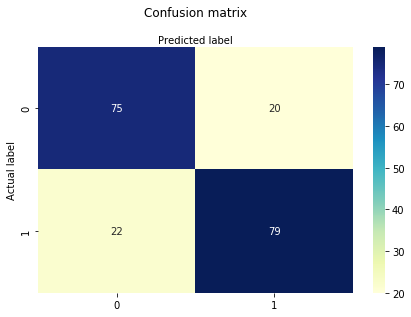

In [73]:
utils.display_confusion_matrix(y_test, y_pred)

In [74]:
prediction_probabilities = bdt.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7857142857142857
Precision: 0.797979797979798
Recall: 0.7821782178217822
Log loss=  0.6797062200667402


In [75]:
# Retrieve the non-normalized game stats
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs


test_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9.0,15.0,-6.0,-0.072,2.0,-6.0,-0.063,1.0,6.0,-5.0,-0.012,-10.243325,1.0,7,-8.63,-3.17,40,33.0,16,38,24.0,37.0,18.0,26.0,45,-1,0.499430
11,2013,64,2013-03-21,8,Colorado State,1a470730-f328-4fb1-8bbf-36a069e4d6b2,9,Missouri,77ca152a-cb2f-48a5-97b2-492351250d94,1,2012,Win,13.65,5.89,0.743,72.0,63.0,0.449,0.715,76.914286,14.0,22.0,11.0,4.0,93.610698,24.0,15.41,6.00,0.676,76.0,66.0,0.459,0.744,80.570588,13.0,23.0,13.0,6.0,94.327225,20.0,Mountain West,Southeastern,36,29.0,21,32,22.0,24.0,28.0,21.0,40,16,24.0,46,36,44.0,18.0,36.0,36.0,17,-1,0,9.0,10.0,-1.0,-0.010,1.0,-1.0,-0.029,7.0,7.0,0.0,0.067,-0.716527,4.0,-1,-1.76,-0.11,20,5.0,-25,-4,-22.0,6.0,-8.0,-15.0,23,-1,0.498087
12,2017,64,2017-03-17,6,Creighton,7d797407-623e-476d-b299-46de4275414d,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,-1,2016,Lose,17.27,8.95,0.714,81.0,72.0,0.504,0.682,80.251429,8.0,26.0,12.0,6.0,100.932783,16.0,12.88,4.62,0.714,73.0,65.0,0.454,0.668,77.840000,11.0,25.0,11.0,6.0,93.782117,22.0,Big East,Atlantic 10,27,26.0,22,23,22.0,27.0,25.0,26.0,27,48,40.0,48,53,43.0,37.0,52.0,31.0,31,0,0,9.0,8.0,1.0,0.050,-3.0,1.0,0.014,6.0,5.0,1.0,0.000,7.150666,-6.0,-5,4.39,4.33,-21,-14.0,-26,-30,-21.0,-10.0,-27.0,-5.0,-4,-1,0.499579
23,2010,16,2010-03-26,3,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,10,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,1,2009,Win,17.97,8.03,0.778,76.0,65.0,0.487,0.725,78.427778,12.0,26.0,13.0,6.0,96.904441,20.0,13.38,2.20,0.824,78.0,66.0,0.484,0.761,76.611765,10.0,25.0,11.0,4.0,101.812039,19.0,Big 12,West Coast,8,13.0,12,10,13.0,12.0,10.0,9.0,11,30,29.0,27,28,27.0,43.0,30.0,35.0,49,1,1,11.0,12.0,-1.0,0.003,2.0,1.0,-0.036,7.0,7.0,0.0,-0.046,-4.907598,1.0,-7,4.59,5.83,-22,-16.0,-15,-18,-14.0,-31.0,-20.0,-26.0,-38,1,0.500698
28,2014,32,2014-03-23,3,Creighton,7d797407-623e-476d-b299-46de4275414d,6,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,-1,2013,Lose,18.03,7.17,0.771,78.0,67.0,0.497,0.743,72.302857,8.0,25.0,9.0,3.0,107.879554,18.0,15.80,10.11,0.684,74.0,67.0,0.455,0.680,77.042105,13.0,24.0,11.0,5.0,96.051373,24.0,Big East,Big 12,11,6.0,12,11,10.0,9.0,16.0,10.0,10,29,30.0,27,25,28.0,31.0,26.0,30.0,27,-1,0,11.0,7.0,4.0,0.042,-5.0,1.0,0.063,6.0,6.0,0.0,0.087,11.828181,-6.0,-3,2.23,-2.94,-18,-24.0,-15,-14,-18.0,-22.0,-10.0,-20.0,-17,1,0.502525


In [76]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Missed predictions= ", missed_predictions.shape[0])


missed_predictions

Missed predictions=  42


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
648,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,16.0,5.0,11.0,0.034,-2.0,-1.0,0.045,3.0,7.0,-4.0,0.306,10.241954,2.0,-7,9.02,-2.17,-26,-29.0,-38,-30,-38.0,-33.0,-38.0,-37.0,-18,1,0.524086
904,2004,64,2004-03-18,9,Southern Illinois,7cdfcf92-7fe7-46f1-9b66-6912114182e6,8,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,-1,2003,Lose,10.70,2.64,0.833,71.0,62.0,0.443,0.689,78.366667,13.0,22.0,12.0,10.0,90.599745,18.0,14.29,10.20,0.606,72.0,68.0,0.451,0.709,76.333333,11.0,23.0,12.0,6.0,94.323144,22.0,Missouri Valley,Southeastern,36,31.0,27,39,22.0,45.0,19.0,25.0,58,33,36.0,31,28,39.0,34.0,45.0,26.0,27,-1,0,9.0,4.0,5.0,-0.008,2.0,-1.0,-0.020,2.0,6.0,-4.0,0.227,-3.723399,-4.0,1,-3.59,-7.56,3,-5.0,-4,11,-17.0,11.0,-26.0,-1.0,31,1,0.523985
416,2003,68,2003-03-18,16,Texas Southern,eb157f98-0697-459c-9293-ddb162ceb28b,16,UNC Asheville,ad9fce12-6b1a-400c-bcbe-29d84d065fc0,-1,2002,Lose,-9.57,-11.21,0.581,73.0,71.0,0.448,0.612,82.045161,13.0,24.0,15.0,6.0,88.975387,28.0,-13.19,-5.61,0.469,72.0,78.0,0.433,0.761,82.125000,12.0,23.0,16.0,7.0,87.671233,20.0,Southwestern Athletic,Big South,257,240.0,246,256,212.0,268.0,239.0,217.0,293,251,237.0,220,250,213.0,273.0,258.0,186.0,277,0,0,2.0,-6.0,8.0,0.015,1.0,1.0,-0.149,9.0,9.0,0.0,0.112,1.304154,8.0,0,3.62,-5.60,6,3.0,26,6,-1.0,-5.0,-19.0,31.0,16,1,0.508661
814,2008,64,2008-03-20,14,Georgia,4f4b0771-994c-4126-822d-7525aaa00f65,3,Xavier,0d8a328f-20ce-410b-bed1-15fc01308aaf,-1,2007,Lose,7.24,7.03,0.500,68.0,67.0,0.429,0.679,79.829412,13.0,24.0,14.0,6.0,85.181637,18.0,17.17,5.47,0.811,75.0,63.0,0.474,0.749,75.335135,11.0,24.0,12.0,5.0,99.555141,22.0,Southeastern,Big East,117,148.0,142,104,143.0,101.0,137.0,152.0,79,10,10.0,12,13,11.0,15.0,12.0,9.0,18,1,1,1.0,12.0,-11.0,-0.045,2.0,0.0,-0.070,8.0,7.0,1.0,-0.311,-14.373504,-4.0,11,-9.93,1.56,107,138.0,130,91,132.0,86.0,125.0,143.0,61,1,0.505845
960,2012,64,2012-03-16,2,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,15,Lehigh,508f503f-dc57-4f4c-a01e-4f195e5c05c8,-1,2011,Lose,17.05,8.40,0.794,77.0,68.0,0.456,0.701,78.694118,11.0,21.0,12.0,6.0,97.847212,25.0,4.27,-5.14,0.771,75.0,65.0,0.444,0.768,77.948571,11.0,20.0,11.0,7.0,96.217286,21.0,Atlantic Coast,Patriot League,11,9.0,9,8,4.0,17.0,8.0,5.0,14,92,87.0,71,111,97.0,83.0,83.0,91.0,113,1,1,9.0,10.0,-1.0,0.012,0.0,1.0,-0.067,6.0,4.0,2.0,0.023,1.629926,4.0,-13,12.78,13.54,-81,-78.0,-62,-103,-93.0,-66.0,-75.0,-86.0,-99,1,0.505767
842,2017,32,2017-03-19,2,Louisville,b795ddbc-baab-4499-8803-52e8608520ab,7,Michigan,bdc2561d-f603-4fab-a262-f1d2af462277,-1,2016,Lose,22.47,11.15,0.735,77.0,65.0,0.457,0.686,80.652941,13.0,26.0,11.0,6.0,95.470790,20.0,18.80,10.17,0.684,75.0,66.0,0.483,0.779,70.357895,7.0,21.0,9.0,5.0,106.597846,16.0,Atlantic

In [77]:
feature_dictionary = utils.Feature_Dictionary()
missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games, 
                                                                      x['season_t'], x['round'], x['team_t'] ), axis=1)


                                    Villanova       North Carolina State     Stat Supports Winner
SOS                              7.55                               9.72         True  (H)
Poss Avg                        73.86                              75.55         True  (H)
Off Rb Avg                      10.00                              12.00         True  (H)
Def Rb Avg                      24.00                              25.00         True  (H)
Seed                              1                                  8          False  (L)
SAG                              6.00                              32.00        False  (L)
WLK                              4.00                              33.00        False  (L)
WOL                              2.00                              40.00        False  (L)
RTH                              2.00                              32.00        False  (L)
COL                              2.00                              40.00        Fal

FG %                            45.00                              49.10        False  (H)
Off Rb Avg                       9.00                              14.00        False  (H)
Def Rb Avg                      20.00                              25.00        False  (H)
FT ATT Avg                      17.00                              27.00        False  (H)
Takeaway Avg                     8.00                               8.00        False  (H)
Margin Victory Avg               4.00                              11.00        False  (H)
Win %                           68.60                              81.80        False  (H)
Off Rating                      96.23                              98.56        False  (H)

 West Virginia Wins.

Supporting Stat Count= 4  out of 26  stats.





648    [(SOS                              7.55       ...
904    [(Seed                              9         ...
416    [(SAG                            257.00       ...
814    [(Seed                             14         ...
960    [(Allow PPG                       68.00       ...
842    [(Turnover Avg                    11.00       ...
316    [(Poss Avg                        77.59       ...
148    [(SRS                             19.51       ...
28     [(SOS                              7.17       ...
472    [(MOR                              4.00       ...
920    [(Allow PPG                       64.00       ...
126    [(Def Rb Avg                      23.00       ...
800    [(Allow PPG                       66.00       ...
688    [(Poss Avg                        75.39       ...
788    [(Seed                             11         ...
832    [(SAG                             66.00       ...
962    [(SAG                             36.00       ...
652    [(PPG                   

In [78]:
supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, feature_dictionary, feature_list),
                                               axis=1)

supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, feature_dictionary, model_features),
                                               axis=1)

In [79]:
missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
    len(model_features)

missed_predictions['game_index'] = missed_predictions.index
missed_predictions.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
648,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,16.0,5.0,11.0,0.034,-2.0,-1.0,0.045,3.0,7.0,-4.0,0.306,10.241954,2.0,-7,9.02,-2.17,-26,-29.0,-38,-30,-38.0,-33.0,-38.0,-37.0,-18,1,0.524086,"[off_rebs_avg, def_rebs_avg, sos]",[sos],13.043478,10.0,648
904,2004,64,2004-03-18,9,Southern Illinois,7cdfcf92-7fe7-46f1-9b66-6912114182e6,8,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,-1,2003,Lose,10.70,2.64,0.833,71.0,62.0,0.443,0.689,78.366667,13.0,22.0,12.0,10.0,90.599745,18.0,14.29,10.20,0.606,72.0,68.0,0.451,0.709,76.333333,11.0,23.0,12.0,6.0,94.323144,22.0,Missouri Valley,Southeastern,36,31.0,27,39,22.0,45.0,19.0,25.0,58,33,36.0,31,28,39.0,34.0,45.0,26.0,27,-1,0,9.0,4.0,5.0,-0.008,2.0,-1.0,-0.020,2.0,6.0,-4.0,0.227,-3.723399,-4.0,1,-3.59,-7.56,3,-5.0,-4,11,-17.0,11.0,-26.0,-1.0,31,1,0.523985,"[fg_pct, def_rebs_avg, ft_pct, off_rating, ft_...","[fg_pct, off_rating, srs, sos, rth, mor]",52.173913,60.0,904
416,2003,68,2003-03-18,16,Texas Southern,eb157f98-0697-459c-9293-ddb162ceb28b,16,UNC Asheville,ad9fce12-6b1a-400c-bcbe-29d84d065fc0,-1,2002,Lose,-9.57,-11.21,0.581,73.0,71.0,0.448,0.612,82.045161,13.0,24.0,15.0,6.0,88.975387,28.0,-13.19,-5.61,0.469,72.0,78.0,0.433,0.761,82.125000,12.0,23.0,16.0,7.0,87.671233,20.0,Southwestern Athletic,Big South,257,240.0,246,256,212.0,268.0,239.0,217.0,293,251,237.0,220,250,213.0,273.0,258.0,186.0,277,0,0,2.0,-6.0,8.0,0.015,1.0,1.0,-0.149,9.0,9.0,0.0,0.112,1.304154,8.0,0,3.62,-5.60,6,3.0,26,6,-1.0,-5.0,-19.0,31.0,16,1,0.508661,"[ft_pct, sos, sag, wlk, wol, rth, rpi, mor]","[sos, rth, rpi, mor]",34.782609,40.0,416
814,2008,64,2008-03-20,14,Georgia,4f4b0771-994c-4126-822d-7525aaa00f65,3,Xavier,0d8a328f-20ce-410b-bed1-15fc01308aaf,-1,2007,Lose,7.24,7.03,0.500,68.0,67.0,0.429,0.679,79.829412,13.0,24.0,14.0,6.0,85.181637,18.0,17.17,5.47,0.811,75.0,63.0,0.474,0.749,75.335135,11.0,24.0,12.0,5.0,99.555141,22.0,Southeastern,Big East,117,148.0,142,104,143.0,101.0,137.0,152.0,79,10,10.0,12,13,11.0,15.0,12.0,9.0,18,1,1,1.0,12.0,-11.0,-0.045,2.0,0.0,-0.070,8.0,7.0,1.0,-0.311,-14.373504,-4.0,11,-9.93,1.56,107,138.0,130,91,132.0,86.0,125.0,143.0,61,1,0.505845,"[margin_victory_avg, fg_pct, ft_pct, to_net_av...","[fg_pct, win_pct, off_rating, srs, rth, col, d...",78.260870,90.0,814
960,2012,64,2012-03-16,2,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,15,Lehigh,508f503f-dc57-4f4c-a01e-4f195e5c05c8,-1,2011,Lose,17.05,8.40,0.794,77.0,68.0,0.456,0.701,78.694118,11.0,21.0,12.0,6.0,97.847212,25.0,4.27,-5.14,0.771,75.0,65.0,0.444,0.768,77.948571,11.0,20.0,11.0,7.0,96.217286,21.0,Atlantic Coast,Patriot League,11,9.0,9,8,4.0,17.0,8.0,5.0,14,92,87.0,71,111,97.0,83.0,

In [80]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
plot_missed_predictions_df.head()

,game_index,Features Supporting Outcome,value
0,648,features,13.043478
1,904,features,52.173913
2,416,features,34.782609
3,814,features,78.260870
4,960,features,13.043478


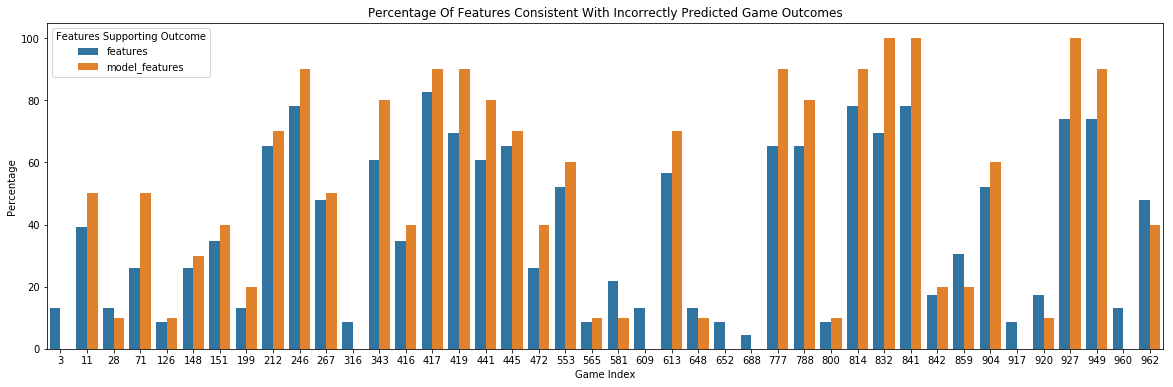

In [81]:
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Incorrectly Predicted Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Game Index')
m_plot.figure.set_size_inches(20,6)

#### End Train Validate Test

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 23)
(782,)
(196, 23)
(196,)


,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
783,0,1,-6.0,-0.056,2.0,-3.0,-0.021,0.0,-0.168,-9.428744,1.0,8,-4.03,2.50,22,20.0,43,39,27.0,20.0,31.0,20.0,14
123,-1,0,2.0,0.004,2.0,-2.0,-0.021,-1.0,0.064,-0.086737,-2.0,1,-2.87,-3.66,25,22.0,3,20,2.0,15.0,18.0,2.0,15
234,-1,1,-3.0,0.002,1.0,3.0,-0.002,3.0,-0.053,-4.493147,-1.0,8,-7.07,-4.22,39,37.0,41,44,36.0,37.0,55.0,39.0,20
718,-1,0,-2.0,0.023,-2.0,2.0,-0.044,3.0,-0.091,-1.465399,-2.0,4,-3.07,-1.64,18,19.0,25,21,26.0,16.0,19.0,24.0,5
807,-1,0,-2.0,0.019,0.0,2.0,-0.009,1.0,-0.008,-1.814245,3.0,3,-1.59,-0.25,13,14.0,21,19,13.0,17.0,16.0,2.0,31


#### Baseline Model

In [40]:
number_estimators = 401

bdt= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R", n_estimators=number_estimators)
    
bdt.fit(X_train, y_train)
score = bdt.score(X_train, y_train)
print("Training Model Score= ", score)


Training Model Score=  0.9910485933503836


In [41]:

important_features = utils.display_important_features( bdt.feature_importances_, X_train)

Coefficient Values
delta_win_pct   0.14713216957605985
delta_sos   0.14713216957605985
delta_srs   0.07231920199501247
delta_dol   0.07231920199501247
delta_col   0.06234413965087282
delta_mor   0.059850374064837904
delta_fg_pct   0.05236907730673317
delta_rpi   0.04239401496259352
delta_off_rating   0.0399002493765586
delta_rth   0.0399002493765586
delta_wlk   0.034912718204488775
delta_wol   0.034912718204488775
delta_ft_pct   0.032418952618453865
delta_margin_victory_avg   0.02743142144638404
delta_pom   0.02493765586034913
delta_ft_att_avg   0.022443890274314215
delta_sag   0.022443890274314215
delta_off_rebs_avg   0.014962593516209476
delta_to_net_avg   0.014962593516209476
delta_seed   0.014962593516209476
top_conf   0.012468827930174564
delta_def_rebs_avg   0.007481296758104738
upset_seed_threshold   0.0


In [42]:
y_pred = bdt.predict(X_test)
print("AdaBoost model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

AdaBoost model accuracy is 0.79


array([[75, 20],
       [22, 79]], dtype=int64)

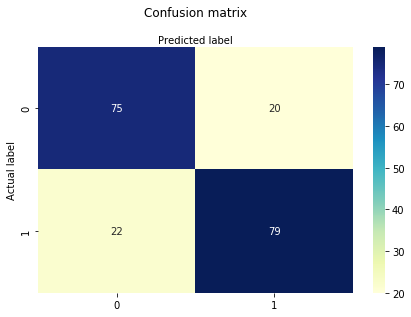

In [43]:
utils.display_confusion_matrix(y_test, y_pred)

##### Baseline Confusion Matrix

In [44]:
prediction_probabilities = bdt.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7857142857142857
Precision: 0.797979797979798
Recall: 0.7821782178217822
Log loss=  0.6797062200667402


In [45]:
cross_val_scores = cross_val_score(bdt, X,y, cv=10, scoring='accuracy')
print("Baseline Cross Validation average= ",cross_val_scores.mean())

Baseline Cross Validation average=  0.7627288028613508


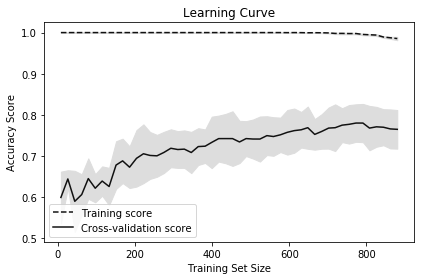

In [46]:
train_sizes, train_scores, test_scores = learning_curve(bdt, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

                   Baseline Learning Curve

#### Model Feature Optimization

In [47]:
X = feature_data[feature_data['season_t']>= tournament_season]
X = X.drop(columns=['season_t'])
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>= tournament_season]['game_result']

model_stats = eliminate_features(bdt, X,y)


Iteration=  0
least_important label=  upset_seed_threshold
Iteration=  1
least_important label=  delta_def_rebs_avg
Iteration=  2
least_important label=  top_conf
Iteration=  3
least_important label=  delta_seed
Iteration=  4
least_important label=  delta_to_net_avg
Iteration=  5
least_important label=  delta_off_rebs_avg
Iteration=  6
least_important label=  delta_sag
Iteration=  7
least_important label=  delta_ft_att_avg
Iteration=  8
least_important label=  delta_pom
Iteration=  9
least_important label=  delta_margin_victory_avg
Iteration=  10
least_important label=  delta_ft_pct
Iteration=  11
least_important label=  delta_wol
Iteration=  12
least_important label=  delta_wlk
Iteration=  13
least_important label=  delta_rth
Iteration=  14
least_important label=  delta_off_rating
Iteration=  15
least_important label=  delta_rpi
Iteration=  16
least_important label=  delta_fg_pct
Iteration=  17
least_important label=  delta_mor
Iteration=  18
least_important label=  delta_col
Iteratio

In [48]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.7857 Cross Val= 0.7627  Log Loss= 0.6797
Accuracy= 0.7857 Cross Val= 0.7627  Log Loss= 0.6797
Accuracy= 0.7908 Cross Val= 0.7638  Log Loss= 0.6810
Accuracy= 0.8061 Cross Val= 0.7638  Log Loss= 0.6822
Accuracy= 0.7908 Cross Val= 0.7607  Log Loss= 0.6801
Accuracy= 0.8061 Cross Val= 0.7678  Log Loss= 0.6794
Accuracy= 0.7908 Cross Val= 0.7781  Log Loss= 0.6793
Accuracy= 0.7908 Cross Val= 0.7658  Log Loss= 0.6793
Accuracy= 0.7500 Cross Val= 0.7801  Log Loss= 0.6794
Accuracy= 0.7704 Cross Val= 0.7872  Log Loss= 0.6802
Accuracy= 0.7653 Cross Val= 0.7852  Log Loss= 0.6801
Accuracy= 0.8112 Cross Val= 0.7791  Log Loss= 0.6777
Accuracy= 0.8010 Cross Val= 0.7904  Log Loss= 0.6789
Accuracy= 0.8061 Cross Val= 0.7925  Log Loss= 0.6787
Accuracy= 0.8214 Cross Val= 0.7883  Log Loss= 0.6774
Accuracy= 0.8316 Cross Val= 0.7853  Log Loss= 0.6787
Accuracy= 0.8316 Cross Val= 0.7924  Log Loss= 0.6807
Accuracy= 0.8010 Cross Val= 0.7781  Log Loss= 0.6803
Accuracy= 0.7908 Cross Val= 0.7770  Log Loss= 

In [49]:
model_features = model_stats[cross_hash]['labels']
print(model_features)

['delta_fg_pct', 'delta_win_pct', 'delta_off_rating', 'delta_srs', 'delta_sos', 'delta_rth', 'delta_col', 'delta_dol', 'delta_rpi', 'delta_mor']


In [50]:
X = feature_data[feature_data['season_t']>= tournament_season][model_features]


array([[75, 20],
       [18, 83]], dtype=int64)

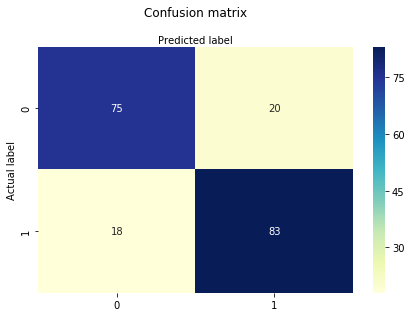

In [51]:
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>= tournament_season]['game_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
bdt.fit(X_train, y_train)
y_pred = bdt.predict(X_test)
# save model stats
prediction_probabilities = bdt.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
log_loss_value = log_loss(y_test, prediction_probabilities)
cross_val_scores = cross_val_score(bdt, X,y, cv=10, scoring='accuracy')
cross_validation_average = cross_val_scores.mean()

train_sizes, train_scores, test_scores = learning_curve(bdt, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
utils.display_confusion_matrix(y_test, y_pred)



In [52]:
utils.display_important_features( bdt.feature_importances_, X_train)

Coefficient Values
delta_sos   0.16458852867830423
delta_win_pct   0.1396508728179551
delta_srs   0.1172069825436409
delta_dol   0.10972568578553615
delta_rpi   0.08728179551122195
delta_mor   0.0798004987531172
delta_fg_pct   0.0773067331670823
delta_off_rating   0.0773067331670823
delta_rth   0.07481296758104738
delta_col   0.07231920199501247


[('delta_sos', 0.16458852867830423),
 ('delta_win_pct', 0.1396508728179551),
 ('delta_srs', 0.1172069825436409),
 ('delta_dol', 0.10972568578553615),
 ('delta_rpi', 0.08728179551122195),
 ('delta_mor', 0.0798004987531172),
 ('delta_fg_pct', 0.0773067331670823),
 ('delta_off_rating', 0.0773067331670823),
 ('delta_rth', 0.07481296758104738),
 ('delta_col', 0.07231920199501247)]

In [53]:
prediction_probabilities = bdt.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.8061224489795918
Precision: 0.8058252427184466
Recall: 0.8217821782178217
Log loss=  0.6787375611266776


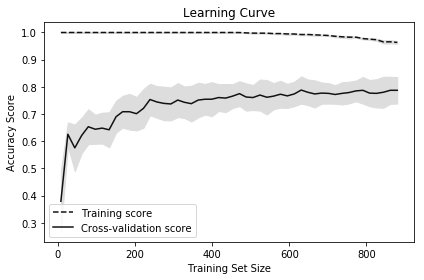

In [54]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [55]:
# Retrieve the non-normalized game stats
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs


test_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9.0,15.0,-6.0,-0.072,2.0,-6.0,-0.063,1.0,6.0,-5.0,-0.012,-10.243325,1.0,7,-8.63,-3.17,40,33.0,16,38,24.0,37.0,18.0,26.0,45,1,0.501666
11,2013,64,2013-03-21,8,Colorado State,1a470730-f328-4fb1-8bbf-36a069e4d6b2,9,Missouri,77ca152a-cb2f-48a5-97b2-492351250d94,1,2012,Win,13.65,5.89,0.743,72.0,63.0,0.449,0.715,76.914286,14.0,22.0,11.0,4.0,93.610698,24.0,15.41,6.00,0.676,76.0,66.0,0.459,0.744,80.570588,13.0,23.0,13.0,6.0,94.327225,20.0,Mountain West,Southeastern,36,29.0,21,32,22.0,24.0,28.0,21.0,40,16,24.0,46,36,44.0,18.0,36.0,36.0,17,-1,0,9.0,10.0,-1.0,-0.010,1.0,-1.0,-0.029,7.0,7.0,0.0,0.067,-0.716527,4.0,-1,-1.76,-0.11,20,5.0,-25,-4,-22.0,6.0,-8.0,-15.0,23,-1,0.498632
12,2017,64,2017-03-17,6,Creighton,7d797407-623e-476d-b299-46de4275414d,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,-1,2016,Lose,17.27,8.95,0.714,81.0,72.0,0.504,0.682,80.251429,8.0,26.0,12.0,6.0,100.932783,16.0,12.88,4.62,0.714,73.0,65.0,0.454,0.668,77.840000,11.0,25.0,11.0,6.0,93.782117,22.0,Big East,Atlantic 10,27,26.0,22,23,22.0,27.0,25.0,26.0,27,48,40.0,48,53,43.0,37.0,52.0,31.0,31,0,0,9.0,8.0,1.0,0.050,-3.0,1.0,0.014,6.0,5.0,1.0,0.000,7.150666,-6.0,-5,4.39,4.33,-21,-14.0,-26,-30,-21.0,-10.0,-27.0,-5.0,-4,-1,0.498585
23,2010,16,2010-03-26,3,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,10,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,1,2009,Win,17.97,8.03,0.778,76.0,65.0,0.487,0.725,78.427778,12.0,26.0,13.0,6.0,96.904441,20.0,13.38,2.20,0.824,78.0,66.0,0.484,0.761,76.611765,10.0,25.0,11.0,4.0,101.812039,19.0,Big 12,West Coast,8,13.0,12,10,13.0,12.0,10.0,9.0,11,30,29.0,27,28,27.0,43.0,30.0,35.0,49,1,1,11.0,12.0,-1.0,0.003,2.0,1.0,-0.036,7.0,7.0,0.0,-0.046,-4.907598,1.0,-7,4.59,5.83,-22,-16.0,-15,-18,-14.0,-31.0,-20.0,-26.0,-38,1,0.500566
28,2014,32,2014-03-23,3,Creighton,7d797407-623e-476d-b299-46de4275414d,6,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,-1,2013,Lose,18.03,7.17,0.771,78.0,67.0,0.497,0.743,72.302857,8.0,25.0,9.0,3.0,107.879554,18.0,15.80,10.11,0.684,74.0,67.0,0.455,0.680,77.042105,13.0,24.0,11.0,5.0,96.051373,24.0,Big East,Big 12,11,6.0,12,11,10.0,9.0,16.0,10.0,10,29,30.0,27,25,28.0,31.0,26.0,30.0,27,-1,0,11.0,7.0,4.0,0.042,-5.0,1.0,0.063,6.0,6.0,0.0,0.087,11.828181,-6.0,-3,2.23,-2.94,-18,-24.0,-15,-14,-18.0,-22.0,-10.0,-20.0,-17,1,0.500894


In [56]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Missed predictions= ", missed_predictions.shape[0])


missed_predictions

Missed predictions=  38


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
648,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,16.0,5.0,11.0,0.034,-2.0,-1.0,0.045,3.0,7.0,-4.0,0.306,10.241954,2.0,-7,9.02,-2.17,-26,-29.0,-38,-30,-38.0,-33.0,-38.0,-37.0,-18,1,0.524113
904,2004,64,2004-03-18,9,Southern Illinois,7cdfcf92-7fe7-46f1-9b66-6912114182e6,8,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,-1,2003,Lose,10.70,2.64,0.833,71.0,62.0,0.443,0.689,78.366667,13.0,22.0,12.0,10.0,90.599745,18.0,14.29,10.20,0.606,72.0,68.0,0.451,0.709,76.333333,11.0,23.0,12.0,6.0,94.323144,22.0,Missouri Valley,Southeastern,36,31.0,27,39,22.0,45.0,19.0,25.0,58,33,36.0,31,28,39.0,34.0,45.0,26.0,27,-1,0,9.0,4.0,5.0,-0.008,2.0,-1.0,-0.020,2.0,6.0,-4.0,0.227,-3.723399,-4.0,1,-3.59,-7.56,3,-5.0,-4,11,-17.0,11.0,-26.0,-1.0,31,1,0.521154
814,2008,64,2008-03-20,14,Georgia,4f4b0771-994c-4126-822d-7525aaa00f65,3,Xavier,0d8a328f-20ce-410b-bed1-15fc01308aaf,-1,2007,Lose,7.24,7.03,0.500,68.0,67.0,0.429,0.679,79.829412,13.0,24.0,14.0,6.0,85.181637,18.0,17.17,5.47,0.811,75.0,63.0,0.474,0.749,75.335135,11.0,24.0,12.0,5.0,99.555141,22.0,Southeastern,Big East,117,148.0,142,104,143.0,101.0,137.0,152.0,79,10,10.0,12,13,11.0,15.0,12.0,9.0,18,1,1,1.0,12.0,-11.0,-0.045,2.0,0.0,-0.070,8.0,7.0,1.0,-0.311,-14.373504,-4.0,11,-9.93,1.56,107,138.0,130,91,132.0,86.0,125.0,143.0,61,1,0.510784
960,2012,64,2012-03-16,2,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,15,Lehigh,508f503f-dc57-4f4c-a01e-4f195e5c05c8,-1,2011,Lose,17.05,8.40,0.794,77.0,68.0,0.456,0.701,78.694118,11.0,21.0,12.0,6.0,97.847212,25.0,4.27,-5.14,0.771,75.0,65.0,0.444,0.768,77.948571,11.0,20.0,11.0,7.0,96.217286,21.0,Atlantic Coast,Patriot League,11,9.0,9,8,4.0,17.0,8.0,5.0,14,92,87.0,71,111,97.0,83.0,83.0,91.0,113,1,1,9.0,10.0,-1.0,0.012,0.0,1.0,-0.067,6.0,4.0,2.0,0.023,1.629926,4.0,-13,12.78,13.54,-81,-78.0,-62,-103,-93.0,-66.0,-75.0,-86.0,-99,1,0.508699
368,2006,64,2006-03-17,15,Davidson,2920c5fa-1e86-4958-a7c4-1e97b8e201d8,2,Ohio State,857462b3-0ab6-4d26-9669-10ca354e382b,-1,2005,Lose,1.89,-3.04,0.645,77.0,68.0,0.454,0.761,80.735484,12.0,26.0,12.0,4.0,95.373182,17.0,16.08,5.90,0.813,73.0,63.0,0.465,0.718,75.387500,10.0,23.0,11.0,6.0,96.833029,18.0,Atlantic 10,Big Ten,125,109.0,114,132,115.0,120.0,127.0,94.0,126,8,6.0,7,6,5.0,9.0,7.0,5.0,12,-1,1,9.0,10.0,-1.0,-0.011,2.0,3.0,0.043,8.0,5.0,3.0,-0.168,-1.459847,-1.0,13,-14.19,-8.94,117,103.0,107,126,110.0,111.0,120.0,89.0,114,1,0.507486
316,2015,68,2015-03-17,16,Manhattan,7a270923-01d6-4a6f-a93e-e8786266d502,16,Hampton,161354af-1f3e-4d58-88f7-e016ec74b7b6,-1,2014,Lose,-1.34,-3.34,0.576,69.0,67.0,0.432,0.691,77.593939,10.0,21.0,14.0,8.0,88.924471,25.0,-8.25,-7.08,0.486,67.0,68.0,0.406,0.652,79.902857,11.0,25.0,14.0,6.0,83.851820,24.0,Metro Atlantic Athletic,Mid Easte

In [58]:
feature_dictionary = utils.Feature_Dictionary()
missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games, 
                                                                      x['season_t'], x['round'], x['team_t'] ), axis=1)


                                    Villanova       North Carolina State     Stat Supports Winner
SOS                              7.55                               9.72         True  (H)
Poss Avg                        73.86                              75.55         True  (H)
Off Rb Avg                      10.00                              12.00         True  (H)
Def Rb Avg                      24.00                              25.00         True  (H)
Seed                              1                                  8          False  (L)
SAG                              6.00                              32.00        False  (L)
WLK                              4.00                              33.00        False  (L)
WOL                              2.00                              40.00        False  (L)
RTH                              2.00                              32.00        False  (L)
COL                              2.00                              40.00        Fal

648    [(SOS                              7.55       ...
904    [(Seed                              9         ...
814    [(Seed                             14         ...
960    [(Allow PPG                       68.00       ...
368    [(Seed                             15         ...
316    [(Poss Avg                        77.59       ...
842    [(Turnover Avg                    11.00       ...
322    [(Seed                             11         ...
920    [(Allow PPG                       64.00       ...
246    [(Seed                             14         ...
688    [(Poss Avg                        75.39       ...
970    [(Seed                             10         ...
28     [(SOS                              7.17       ...
832    [(SAG                             66.00       ...
788    [(Seed                             11         ...
800    [(Allow PPG                       66.00       ...
212    [(SAG                              3.00       ...
354    [(Seed                  

In [59]:
supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, feature_dictionary, feature_list),
                                               axis=1)

supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, feature_dictionary, model_features),
                                               axis=1)

In [60]:
missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
    len(model_features)

missed_predictions['game_index'] = missed_predictions.index
missed_predictions.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
648,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,16.0,5.0,11.0,0.034,-2.0,-1.0,0.045,3.0,7.0,-4.0,0.306,10.241954,2.0,-7,9.02,-2.17,-26,-29.0,-38,-30,-38.0,-33.0,-38.0,-37.0,-18,1,0.524113,"[off_rebs_avg, def_rebs_avg, sos]",[sos],13.043478,10.0,648
904,2004,64,2004-03-18,9,Southern Illinois,7cdfcf92-7fe7-46f1-9b66-6912114182e6,8,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,-1,2003,Lose,10.70,2.64,0.833,71.0,62.0,0.443,0.689,78.366667,13.0,22.0,12.0,10.0,90.599745,18.0,14.29,10.20,0.606,72.0,68.0,0.451,0.709,76.333333,11.0,23.0,12.0,6.0,94.323144,22.0,Missouri Valley,Southeastern,36,31.0,27,39,22.0,45.0,19.0,25.0,58,33,36.0,31,28,39.0,34.0,45.0,26.0,27,-1,0,9.0,4.0,5.0,-0.008,2.0,-1.0,-0.020,2.0,6.0,-4.0,0.227,-3.723399,-4.0,1,-3.59,-7.56,3,-5.0,-4,11,-17.0,11.0,-26.0,-1.0,31,1,0.521154,"[fg_pct, def_rebs_avg, ft_pct, off_rating, ft_...","[fg_pct, off_rating, srs, sos, rth, mor]",52.173913,60.0,904
814,2008,64,2008-03-20,14,Georgia,4f4b0771-994c-4126-822d-7525aaa00f65,3,Xavier,0d8a328f-20ce-410b-bed1-15fc01308aaf,-1,2007,Lose,7.24,7.03,0.500,68.0,67.0,0.429,0.679,79.829412,13.0,24.0,14.0,6.0,85.181637,18.0,17.17,5.47,0.811,75.0,63.0,0.474,0.749,75.335135,11.0,24.0,12.0,5.0,99.555141,22.0,Southeastern,Big East,117,148.0,142,104,143.0,101.0,137.0,152.0,79,10,10.0,12,13,11.0,15.0,12.0,9.0,18,1,1,1.0,12.0,-11.0,-0.045,2.0,0.0,-0.070,8.0,7.0,1.0,-0.311,-14.373504,-4.0,11,-9.93,1.56,107,138.0,130,91,132.0,86.0,125.0,143.0,61,1,0.510784,"[margin_victory_avg, fg_pct, ft_pct, to_net_av...","[fg_pct, win_pct, off_rating, srs, rth, col, d...",78.260870,90.0,814
960,2012,64,2012-03-16,2,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,15,Lehigh,508f503f-dc57-4f4c-a01e-4f195e5c05c8,-1,2011,Lose,17.05,8.40,0.794,77.0,68.0,0.456,0.701,78.694118,11.0,21.0,12.0,6.0,97.847212,25.0,4.27,-5.14,0.771,75.0,65.0,0.444,0.768,77.948571,11.0,20.0,11.0,7.0,96.217286,21.0,Atlantic Coast,Patriot League,11,9.0,9,8,4.0,17.0,8.0,5.0,14,92,87.0,71,111,97.0,83.0,83.0,91.0,113,1,1,9.0,10.0,-1.0,0.012,0.0,1.0,-0.067,6.0,4.0,2.0,0.023,1.629926,4.0,-13,12.78,13.54,-81,-78.0,-62,-103,-93.0,-66.0,-75.0,-86.0,-99,1,0.508699,"[margin_victory_avg, ft_pct, to_net_avg]",[],13.043478,0.0,960
368,2006,64,2006-03-17,15,Davidson,2920c5fa-1e86-4958-a7c4-1e97b8e201d8,2,Ohio State,857462b3-0ab6-4d26-9669-10ca354e382b,-1,2005,Lose,1.89,-3.04,0.645,77.0,68.0,0.454,0.761,80.735484,12.0,26.0,12.0,4.0,95.373182,17.0,16.08,5.90,0.813,73.0,63.0,0.465,0.718,75.387500,10.0,23.0,11.0,6.0,96.833029,18.0,Atlantic 10,Big Ten,125,109.0,114,132,115.0,120.0,127.0,94.0,126,8,6.0,7,6,5.0,9.0,7.0,5.0,12,-1,1,9.0,10.0,-1.0,-0.011,2.0,3.0,0.04

In [61]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
plot_missed_predictions_df.head()

,game_index,Features Supporting Outcome,value
0,648,features,13.043478
1,904,features,52.173913
2,814,features,78.260870
3,960,features,13.043478
4,368,features,78.260870


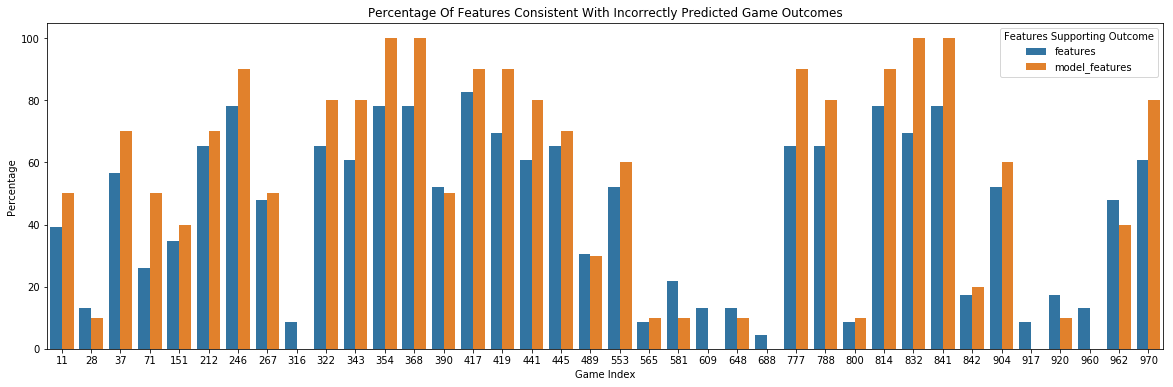

In [62]:
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Incorrectly Predicted Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Game Index')
m_plot.figure.set_size_inches(20,6)

#### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.